# Character Segmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Import Widgets
import ipywidgets as widgets
from IPython.display import display, clear_output

# Import costume functions, corresponding to notebooks
from detect import page, words

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0-dev
Numpy: 1.12.0
TensorFlow: 1.0.0-rc1


In [2]:
def implt(img, cmp=None, t=''):
    """ Show image using plt """
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()
    
    
def resize(img, height, allways=False):
    """ Resize image to given height """
    if (img.shape[0] > height or allways):
        rat = height / img.shape[0]
        return cv2.resize(img, (int(rat * img.shape[1]), height))
    
    return img

## Load Image and Separate Words

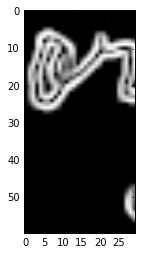

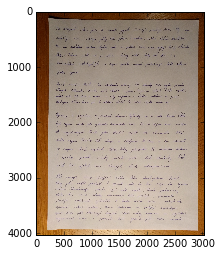

In [3]:
IMG = "text"

image = cv2.cvtColor(cv2.imread("data/pagedet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
testGap = cv2.imread("data/gapdet/1/1488226741.053654.jpg", 0)

implt(testGap, 'gray')
implt(image)

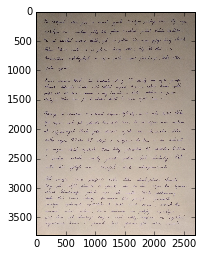

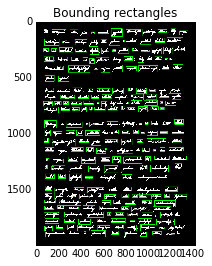

In [4]:
crop = page.detection(image)
implt(crop)
bBoxes = words.detection(crop)

## Load Trained Model

In [5]:
# Recovering the session and getting activation function
sess = tf.InteractiveSession()

saver = tf.train.import_meta_graph('models/CNN-CG.meta', clear_devices=True)
saver.restore(sess, 'models/CNN-CG')

activation = tf.get_collection("activation")[0]

# b_fc2 contains two values, which should be different from 0.1
print(activation)
print(sess.run("b_fc2:0"))
print("Successfully loaded.")

INFO:tensorflow:Restoring parameters from models/CNN-CG
Tensor("ArgMax:0", shape=(?,), dtype=int64)
[ 0.10284831  0.09715168]
Successfully loaded.


## Applying Model

In [6]:
def wordTilt(img, height):
    edges = cv2.Canny(img, 50, 150, apertureSize = 3)
    lines = cv2.HoughLines(edges, 1, np.pi/180, 30)
    
    if lines is not None:
        meanAngle = 0
        # Set min number of valid lines (try higher)
        numLines = np.sum(1 for l in lines if l[0][1] < 0.7 or l[0][1] > 2.6)
        if numLines > 1:
            meanAngle = np.median([l[0][1] for l in lines if l[0][1] < 0.7 or l[0][1] > 2.6])

        # Look for angle with correct value
        if meanAngle != 0 and (meanAngle < 0.7 or meanAngle > 2.6):
            img = tiltByAngle(img, meanAngle, height)
    
    return cropAddBorder(img, height, 50)

        
def tiltByAngle(img, angle, height):
    dist = np.tan(angle) * height
    width = len(img[0])
    sPoints = np.float32([[0,0], [0,height], [width,height], [width,0]])
    
    # Dist is positive for angle < 0.7; negative for angle > 2.6
    # Image must be shifed to right
    if dist > 0:
        tPoints = np.float32([[0,0], [dist,height], [width+dist,height], [width,0]])
    else:
        tPoints = np.float32([[-dist,0], [0,height], [width,height], [width-dist,0]])

    M = cv2.getPerspectiveTransform(sPoints, tPoints)
    return cv2.warpPerspective(img, M, (int(width+abs(dist)), height))


def sobelDetect(channel):
    """ The Sobel Operator"""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    # Combine x, y gradient magnitudes sqrt(x^2 + y^2)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return sobel


def imgPreprocess(image, height):
    """ Preprocess image for """
    # @TODO - Need speed up -> configure bilateral fileter
    img = cv2.bilateralFilter(image, 0, 30, 30)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # @TODO Can try only revers colors on grayscale image
    # reversGray = cv2.bitwise_not(gray)
    
    edges = np.uint8(sobelDetect(gray))
    ret,th = cv2.threshold(edges, 50, 255, cv2.THRESH_TOZERO)
    return wordTilt(th, height)


def cropAddBorder(img, height, tol=0):
    # Clear small values
    img[img < 40] = 0
    # Mask of pixels brighter than tolerance
    mask = img > tol
    coords = np.argwhere(mask)
    # Bounding box of non-black pixels.
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    # Croping image
    resize(img[x0:x1, y0:y1], height, True), 
    return cv2.copyMakeBorder(img, 0, 0, 15, 15, cv2.BORDER_CONSTANT, value=[0, 0, 0])

In [7]:
class Cycler:
    """ Cycle through boxes, save data """
    width = 30
    height = 60
    step = 2
    
    def __init__(self, image, boxes, idx):
        self.boxes = boxes       # Array of bounding boxes
        self.image = image       # Whole image
        self.index = idx         # Index of current bounding box
        self.pos = 0             # Position po slider
        self.actual = image      # Current image of word, drawing lines
        self.actualG = image     # Current slider image, evaluating
        self.nextImg(boxes)
    
    def nextPos(self):
        """ Sliding over image and classifiing"""      
        
        # Getting Array of Sep Lines
        gaps = []
        isPrevGap = True
        gapPositionSum = self.pos + self.width/2
        gapCount = 1
        separate = False
        gapsImage = self.actual.copy()
        
        while self.pos < len(self.actual[0]) - self.width:            
            img = self.actualG[0:self.height, self.pos:self.pos + self.width]
            
            # CharGapClassifier prediction
            # Green - characters
            # Red   - gaps
            
            # Pixel transform and rescale
            data = np.multiply(np.reshape(img, (1, 1800)).astype(np.float32),
                               1.0 / 255.0)
            
            if activation.eval(feed_dict={"x:0": data}) == 1:
                # If is GAP - add possition to sum
                gapPositionSum += self.pos + self.width/2
                gapCount += 1
                isPrevGap = True
                separate = False
                
                # Plotting all lines
                cv2.line(self.actual,
                         ((int)(self.pos + self.width/2),0),
                         ((int)(self.pos + self.width/2),
                         self.height), (255,0,0), 1)
            else:
                # Add gap position into array 
                # only if two letter lines detected
                if not separate and isPrevGap:
                    separate = True
                elif separate:
                    gaps.append(gapPositionSum / gapCount)
                    gapPositionSum = 0
                    gapCount = 0
                    separate = False
                    
                isPrevGap = False
                
                # Plotting all lines
                cv2.line(self.actual,
                         ((int)(self.pos + self.width/2),0),
                         ((int)(self.pos + self.width/2),
                         self.height), (0,255,0), 1)                
            
            self.pos += self.step           
        
        gapPositionSum += self.pos + self.width/2
        gapCount += 1
        gaps.append(gapPositionSum / gapCount)
        
        implt(self.actual)
        
        print("GAPS")
        for gap in gaps:
            cv2.line(gapsImage,
                     ((int)(gap),0),
                     ((int)(gap),
                     self.height), (0,255,0), 1)
        print(gaps)
        implt(gapsImage)
            

    def nextImg(self, b):
        """ Getting next image from the array """
        clear_output()
        
        self.pos = 0
        if self.index < len(self.boxes):
            b = self.boxes[self.index]
            x1, y1, x2, y2 = b
            
            # Cuting out the word image and resizing to standard height
            img = self.image[y1:y2, x1:x2]
            img = resize(img, self.height, True)
            implt(img, 'gray', 'Original')            
            
            img = imgPreprocess(img, self.height)

            self.actual = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            self.actualG = img         
            
            self.nextPos()
            
            # Printing index for recovery
            print("Index: " + str(self.index))
            
            self.index += 1
            return 0
        else:
            print("END")
            return -1

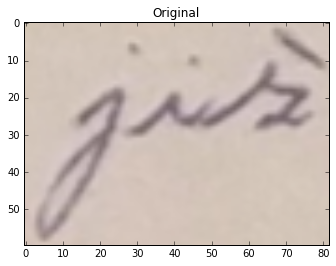

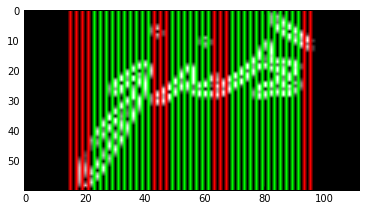

GAPS
[17.4, 45.0, 65.0, 95.0]


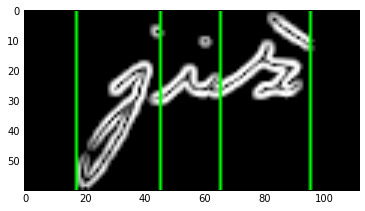

Index: 1


In [8]:
# Class cycling through text positions
# Green - Characters
# Red   - Gaps
LAST_INDEX = 1
cycler = Cycler(crop, bBoxes, LAST_INDEX)

bNexi = widgets.Button(description="Next Image")
    
bNexi.on_click(cycler.nextImg)

display(bNexi)